In [ ]:
# default_exp gcp_helpers

# EUMETSAT and Google Cloud Platform (GCP) 

The intention is to run a DAG using Airflow that:  

1. Uses the EUMETSAT DownloadManager will check for available files over a time period.  
2. Compares with already downloaded files in a GCP bucket
3. Downloads any files not already downloaded, compressed using `pbzip2`

Run on europe-west4 (Netherlands) by preference.  

Our bucket and an example folder prefix is defined below.  

The data is stored in the format `gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/native/<year>/<month>/<day>/<hour>/<minute>/` as per the existing files.

### Setup

In [ ]:
#exports
from google.cloud import storage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import dotenv
import pandas_gbq

<br>

### GCP Helpers

First need a couple of helper functions to work with Google Cloud Platform.  
Ideally the principles will transfer easily to other cloud providers if necessary. 

First we want to be able to list files ('blobs') in a Google Cloud storage bucket, and get the metadata for a specific file ('blob').

In [ ]:
# You may need to run the following to create locally stored account credentials
# https://googleapis.dev/python/google-api-core/latest/auth.html
# !gcloud auth application-default login

In [ ]:
#exports
def list_blobs_with_prefix(bucket_name, prefix, delimiter=None):
    """Lists all the blobs in the bucket that begin with the prefix.

    This can be used to list all blobs in a "folder", e.g. "public/".

    The delimiter argument can be used to restrict the results to only the
    "files" in the given "folder". Without the delimiter, the entire tree under
    the prefix is returned. For example, given these blobs:

        a/1.txt
        a/b/2.txt

    If you just specify prefix = 'a', you'll get back:

        a/1.txt
        a/b/2.txt

    However, if you specify prefix='a' and delimiter='/', you'll get back:

        a/1.txt

    Additionally, the same request will return blobs.prefixes populated with:

        a/b/
    """

    storage_client = storage.Client()

    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name, prefix=prefix, delimiter=delimiter)

    names = []

    for blob in blobs:
        names.append(blob.name)
    return names


def blob_metadata(bucket_name, blob_name):
    """Prints out a blob's metadata."""
    # bucket_name = 'your-bucket-name'
    # blob_name = 'your-object-name'

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.get_blob(blob_name)

    print("Blob: {}".format(blob.name))
    print("Bucket: {}".format(blob.bucket.name))
    print("Storage class: {}".format(blob.storage_class))
    print("ID: {}".format(blob.id))
    print("Size: {} bytes".format(blob.size))
    print("Updated: {}".format(blob.updated))
    print("Generation: {}".format(blob.generation))
    print("Metageneration: {}".format(blob.metageneration))
    print("Etag: {}".format(blob.etag))
    print("Owner: {}".format(blob.owner))
    print("Component count: {}".format(blob.component_count))
    print("Crc32c: {}".format(blob.crc32c))
    print("md5_hash: {}".format(blob.md5_hash))
    print("Cache-control: {}".format(blob.cache_control))
    print("Content-type: {}".format(blob.content_type))
    print("Content-disposition: {}".format(blob.content_disposition))
    print("Content-encoding: {}".format(blob.content_encoding))
    print("Content-language: {}".format(blob.content_language))
    print("Metadata: {}".format(blob.metadata))

<br>

We also want to be able to upload a file ('blob') to a storage bucket in an efficient way.

In [ ]:
#exports
def upload_blob(bucket_name, source_file_name, destination_blob_name, prefix=None, log=None):
    """Uploads a file to the bucket."""
    # bucket_name = "your-bucket-name"
    # source_file_name = "local/path/to/file"
    # destination_blob_name = "storage-object-name"

    if prefix:
        destination_blob_name = prefix + destination_blob_name
    
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    # For slow upload speed
    storage.blob._DEFAULT_CHUNKSIZE = 2097152 # 1024 * 1024 B * 2 = 2 MB
    storage.blob._MAX_MULTIPART_SIZE = 2097152 # 2 MB
    
    blob.upload_from_filename(source_file_name)

    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )
    if log:
        log.info("File {} uploaded to {}.".format(
                source_file_name, destination_blob_name
            )
        )

<br>

### Checking existing saved data in Google Cloud Storage

Finding out how much data has been downloaded for different years in the OCF native data bucket.

In [ ]:
BUCKET_NAME = "solar-pv-nowcasting-data"
PREFIX = "satellite/EUMETSAT/SEVIRI_RSS/native/2019/01/01"
blobs = list_blobs_with_prefix(BUCKET_NAME, prefix=PREFIX)

In [ ]:
print(f'There are {len(blobs)} files')

There are 277 files


<br>

Lets see how large the data for the whole of 2018 is - this may take a few minutes to run. 

In [ ]:
storage_client = storage.Client()
PREFIX = "satellite/EUMETSAT/SEVIRI_RSS/native/2021/"

# Note: Client.list_blobs requires at least package version 1.17.0.
blobs_ = storage_client.list_blobs(BUCKET_NAME, prefix=PREFIX)

sizes = []

for blob in blobs_:
    sizes.append(blob.size)

In [ ]:
sum(sizes) / 1e9

226.886050375

<br>

2018 contains 2.4TB of data

Note that using the storage client to return blobs returns an iterable of blob metadata objects.  
From those we've extracted the names. We can go backwards from the names to interact with the blobs. 

In [ ]:
BUCKET_NAME = "solar-pv-nowcasting-data"
PREFIX = "satellite/EUMETSAT/SEVIRI_RSS/native/2021"
blobs = list_blobs_with_prefix(BUCKET_NAME, prefix=PREFIX)

In [ ]:
df = pd.DataFrame(blobs, columns=['blobs'])
df = df[df['blobs'].str.endswith('.nat.bz2')] # only compressed data files
df['datetime'] = pd.to_datetime(df['blobs'].str.slice(start=37, stop=53), format="%Y/%m/%d/%H/%M")

<br>

It is helpful to see by month how many data files already exist as compressed .nat files.  
Note that this is not looking at files reprojected and stored in the Zarr database.

In [ ]:
months_in_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [ ]:
blobs_by_month = df\
        .assign(year=lambda x: x['datetime'].dt.year)\
        .assign(month=lambda x: x['datetime'].dt.month_name())\
        .groupby(['month', 'year']).count()['blobs'].to_frame()\
        .reset_index()\
        .pivot(index='month', columns='year', values='blobs')\
        .reindex(months_in_order)

blobs_by_month

year,2021
month,
January,6695.0
February,289.0
March,NaN
April,NaN
May,NaN
June,NaN
July,NaN
August,NaN
September,NaN


<br>

And lets plot this 

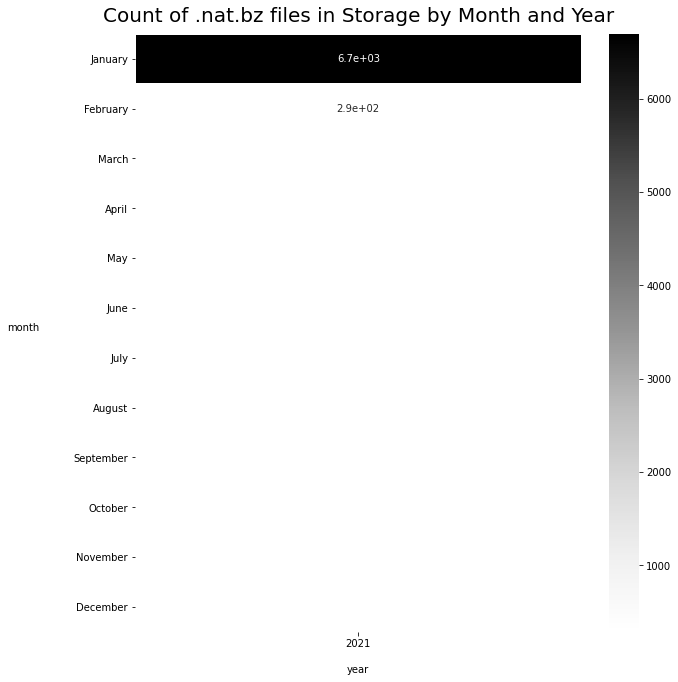

In [ ]:
# credit: https://dfrieds.com/data-visualizations/visualize-historical-time-comparisons.html

figure, axes = plt.subplots(figsize=(10, 11))
sns.heatmap(blobs_by_month, annot=True, linewidths=.5, ax=axes, cmap="Greys")
axes.axes.set_title("Count of .nat.bz files in Storage by Month and Year", fontsize=20, y=1.01)
axes.axes.set_ylabel("month", labelpad=50, rotation=0)
axes.axes.set_xlabel("year", labelpad=16);
plt.yticks(rotation=0);

<br>

Sometimes we'll want all of the original (uncompressed) filenames - for example to compare with the results of the EUMETSAT API so we can work out whether we should request a file or not.  
We'll make a function to get original filenames from compressed or uncompressed files stored as blobs on GCP.

In [ ]:
filenames = df['blobs'].str.split('/').str[-1].str.replace('.bz2', '')

In [ ]:
#exports
def get_eumetsat_filenames(bucket_name, prefix, delimiter=None):
    """Lists all the blobs in the bucket that begin with the prefix.

    This can be used to list all blobs in a "folder", e.g. "public/".

    The delimiter argument can be used to restrict the results to only the
    "files" in the given "folder". Without the delimiter, the entire tree under
    the prefix is returned. For example, given these blobs:

    """

    storage_client = storage.Client()

    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name, prefix=prefix, delimiter=delimiter)

    names = []

    for blob in blobs:
        if blob.name.endswith('.nat.bz2'):
            filename = blob.name.split('/')[-1].replace('.bz2', '')
            names.append(filename)
    return names

In [ ]:
PREFIX = "satellite/EUMETSAT/SEVIRI_RSS/native/2019/10/01"
filenames = get_eumetsat_filenames(BUCKET_NAME, prefix=PREFIX)

In [ ]:
len(filenames)

288

## Write metadata to bigquery

For cloud storage functions, storing metadata in a RDBS seems useful. BigQuery is a low hassle way to achieve this and can scale to lots of data with ease.  
Downsides are rather inflexible migrations and updates.  


In [ ]:
# exports
def write_metadata_to_gcp(df, table_id, project_id, credentials=None, append=True):
    if append:
        if_exists = "append"
    else:
        if_exists = "fail"
        
    if credentials:
        pandas_gbq.to_gbq(
            df,
            table_id,
            project_id=project_id,
            credentials=credentials,
            if_exists=if_exists,
        )
    else:
        pandas_gbq.to_gbq(
            df,
            table_id,
            project_id=project_id,
            if_exists=if_exists,
        )
        
    print(
        f"{len(df)} rows written to BQ {table_id}, append={append}"
    )

In [ ]:
write_metadata_now = False

if write_metadata_now == True:
    write_metadata_to_gcp(df, 'test', 'solar-pv-nowcasting')

<br>

As well as writing to BigQuery, we also want to query it. We'll write a small wrapper that allows us to send any SQL query and get results as a pandas DataFrame. Naturally we need to know the GCP project id, and the BigQuery table name.

In [ ]:
#exports
def query(sql_query, project_id):
    """Wrapper around BigQuery for a given Google project
        
        Returns:
            pandas.DataFrame of the query results
    """
    df = pandas_gbq.read_gbq(sql_query, project_id=project_id)
    
    return df

sql_query = 'select * from eumetsat.metadata where result_time = (select max(result_time) from eumetsat.metadata)'
project_id = 'solar-pv-nowcasting'

query(sql_query, project_id)['result_time'].iloc[0].strftime('%Y-%m-%d %H:%M')

Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.09rows/s]


'2021-02-02 08:44'

In [ ]:
#hide
from nbdev.export import *
notebook2script('04_gcp.ipynb')

Converted 04_gcp.ipynb.
